In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import completions_module as cmodule

import cartopy.crs as crs
import cartopy.feature as cf
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib as mpl
import geopandas
from cartopy import crs as ccrs

Load data.

In [2]:
# states for plotting (from figure 1)

df = geopandas.read_file('../data/tl_2020_us_state.shp')
latinx_data = pd.read_excel('../data/census2020_latinx.xlsx',
                            engine='openpyxl')

df = df[np.isin(df['NAME'].values,latinx_data['STATE'].values)]
latinx_data = latinx_data[np.isin(latinx_data['STATE'].values,
                                  df['NAME'].values)]

df = df.reset_index(drop=True).set_index('NAME')
latinx_data = latinx_data.reset_index(drop=True).rename(
    columns={"STATE": "NAME"}).set_index('NAME')

df = df[(df.index!='Alaska')&(df.index!='Hawaii')]

df = pd.concat([df, latinx_data], axis=1, sort=True).reindex(
    df.index)

crs_ = ccrs.LambertConformal()  # Define the CartoPy CRS object.
crs_proj4 = crs_.proj4_init
df_lc = df#.to_crs(crs_proj4)

In [3]:
# ucar list
all_files = glob.glob("../data/completions_*.csv")
all_files = sorted(all_files)
df_ucar = cmodule.open_and_concat(all_files)

# hsi list
all_files = glob.glob("../data/hsi_completions_*.csv")
all_files = sorted(all_files)
df_hsis = cmodule.open_and_concat(all_files)

# ehi list
all_files = glob.glob("../data/emerginghsi_completions_*.csv")
all_files = sorted(all_files)
df_ehis = cmodule.open_and_concat(all_files)

# uni locations
uni_loc = pd.read_csv('../data/hd2020_data_stata.csv', 
                      encoding='ISO-8859-1')  # uni locations

Concatenate the data from UCAR, HSI, EHI lists.

In [4]:
all_unis = pd.concat([df_ucar, df_hsis, df_ehis])

### Filter top ranked schools

In [5]:
# -------

top_cut = 30

# -------

df = cmodule.bs_degrees(all_unis)
df = cmodule.atmospheric_sciences(df)

school_names = df.groupby(
    'institution name').sum()['Hispanic or Latino total'].sort_values(
    ascending=False).head(top_cut).index

df = df[df['institution name'].isin(school_names)].groupby(
    'institution name').sum()[['Hispanic or Latino total']]

top_his_atm = df.sort_values('Hispanic or Latino total',ascending=False).head(
    top_cut)

# -------

df = cmodule.bs_degrees(all_unis)
df = cmodule.atmospheric_sciences(df)

school_names = df.groupby(
    'institution name').sum()['Grand total'].sort_values(
    ascending=False).head(top_cut).index

df = df[df['institution name'].isin(school_names)].groupby(
    'institution name').sum()[['Grand total']]

top_all_atm = df.sort_values('Grand total',ascending=False).head(top_cut)

# -------

df = cmodule.bs_degrees(all_unis)
df = cmodule.earth_and_atmos_sciences(df)

school_names = df.groupby(
    'institution name').sum()['Hispanic or Latino total'].sort_values(
    ascending=False).head(top_cut).index

df = df[df['institution name'].isin(school_names)].groupby(
    'institution name').sum()[['Hispanic or Latino total']]

top_his_eas = df.sort_values('Hispanic or Latino total',ascending=False).head(
    top_cut)

# -------

df = cmodule.bs_degrees(all_unis)
df = cmodule.earth_and_atmos_sciences(df)

school_names = df.groupby(
    'institution name').sum()['Grand total'].sort_values(
    ascending=False).head(top_cut).index

df = df[df['institution name'].isin(school_names)].groupby(
    'institution name').sum()[['Grand total']]

top_all_eas = df.sort_values('Grand total',ascending=False).head(top_cut)

# -------

Identify school names that don't match lists

In [6]:
for num, i in enumerate(top_his_atm.index):
    if uni_loc[uni_loc['INSTNM']==i][['INSTNM','LONGITUD','LATITUDE']].empty:
        print(i)
        
for num, i in enumerate(top_all_atm.index):
    if uni_loc[uni_loc['INSTNM']==i][['INSTNM','LONGITUD','LATITUDE']].empty:
        print(i)
        
for num, i in enumerate(top_his_eas.index):
    if uni_loc[uni_loc['INSTNM']==i][['INSTNM','LONGITUD','LATITUDE']].empty:
        print(i)
        
for num, i in enumerate(top_all_eas.index):
    if uni_loc[uni_loc['INSTNM']==i][['INSTNM','LONGITUD','LATITUDE']].empty:
        print(i)

University of Illinois at Urbana-Champaign
University of Illinois at Urbana-Champaign
University of Illinois at Urbana-Champaign


In [7]:
#uni_loc[uni_loc['STABBR']=='NY']['INSTNM'].unique()

Grab uni locations

In [8]:
def grab_uni_locations(top_, uni_loc):
    """
    Extract the locations of the filtered universities.
    
    Args:
        top_: list of top schools.
        uni_loc: dataframe of school locations.
        
    """
    uni_ = []
    lat_ = []
    lon_ = []
    frq_ = []

    for num, i in enumerate(top_.index):

        if not uni_loc[uni_loc['INSTNM']==i][['INSTNM','LONGITUD','LATITUDE']].empty:

            uni_.append(uni_loc[uni_loc['INSTNM']==i]['INSTNM'].to_numpy()[0])
            lon_.append(uni_loc[uni_loc['INSTNM']==i]['LONGITUD'].to_numpy()[0])
            lat_.append(uni_loc[uni_loc['INSTNM']==i]['LATITUDE'].to_numpy()[0])
            frq_.append(top_.iloc[num].values)

        if uni_loc[uni_loc['INSTNM']==i][['INSTNM','LONGITUD','LATITUDE']].empty:

            if i == 'University of Illinois at Urbana-Champaign':

                uni_.append(uni_loc[uni_loc['INSTNM'].str.contains(
                    'University of Illinois Urbana-Champaign')]['INSTNM'].to_numpy()[0])
                lon_.append(uni_loc[uni_loc['INSTNM'].str.contains(
                    'University of Illinois Urbana-Champaign')]['LONGITUD'].to_numpy()[0])
                lat_.append(uni_loc[uni_loc['INSTNM'].str.contains(
                    'University of Illinois Urbana-Champaign')]['LATITUDE'].to_numpy()[0])
                frq_.append(top_.iloc[num].values)

            if i == 'SUNY College at Brockport':

                uni_.append(uni_loc[uni_loc['INSTNM'].str.contains(
                    'SUNY Brockport')]['INSTNM'].to_numpy()[0])
                lon_.append(uni_loc[uni_loc['INSTNM'].str.contains(
                    'SUNY Brockport')]['LONGITUD'].to_numpy()[0])
                lat_.append(uni_loc[uni_loc['INSTNM'].str.contains(
                    'SUNY Brockport')]['LATITUDE'].to_numpy()[0])
                frq_.append(top_.iloc[num].values)
                
    return uni_, lat_, lon_, np.array(frq_)

def minmax_norm(frq_):
    return (frq_ - frq_.min()) / (frq_.max() - frq_.min())

def minmax_norm_reverse(new_, frq_):
    return (new_ * (frq_.max() - frq_.min())) + frq_.min()

In [9]:
uni_all_atm, lat_all_atm, lon_all_atm, frq_all_atm = grab_uni_locations(top_all_atm, uni_loc)
uni_his_atm, lat_his_atm, lon_his_atm, frq_his_atm = grab_uni_locations(top_his_atm, uni_loc)
uni_all_eas, lat_all_eas, lon_all_eas, frq_all_eas = grab_uni_locations(top_all_eas, uni_loc)
uni_his_eas, lat_his_eas, lon_his_eas, frq_his_eas = grab_uni_locations(top_his_eas, uni_loc)

Cartopy states

In [10]:
reader = shpreader.Reader(
    f'/glade/work/molina/DATA/cartopy_usstates/ne_50m_admin_1_states_provinces_lines.shp')
states = list(reader.geometries())
STATES = cfeature.ShapelyFeature(states, crs.PlateCarree())

### figure

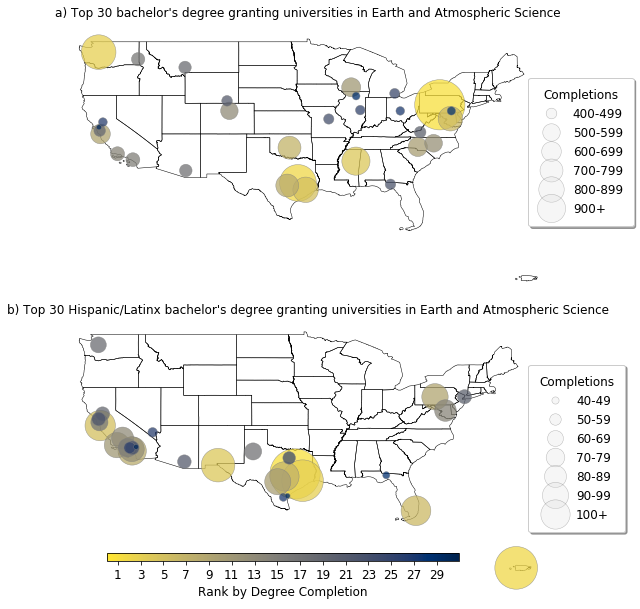

In [11]:
#-----------------------%

fig = plt.figure(figsize=(7.,8.))

#-----------------------%

ax1 = fig.add_axes([0., 0.5, 1., 0.5], projection=ccrs.LambertConformal())

ax1.set_title(
    f"a) Top {top_cut} bachelor's degree granting universities in Earth and Atmospheric Science",
    fontsize=12)

#-----------------------%

cs1 = df_lc.plot(column=None, edgecolor='k', facecolor='none',
                 lw=0.5, ax=ax1,)

#-----------------------%

scatter = ax1.scatter(x=lon_all_eas, y=lat_all_eas, c=np.arange(1,len(uni_all_eas)+1,1), 
                      s=(minmax_norm(frq_all_eas) + 0.01) * 2500, cmap='cividis_r', 
                      alpha=0.75, edgecolor='grey', lw=0.5, vmin=0, vmax=31,
                      transform=ccrs.LambertConformal(), zorder=10)
    
#-----------------------%

handles, labels = scatter.legend_elements(prop="sizes", num=None, alpha=0.25, 
                                          color="gainsboro", markeredgecolor='k')

labels_list = []
for lab in labels:
    labels_list.append(int(lab.split('{')[1].split('}')[0]))
labels_list = np.array(labels_list)
labels_list = minmax_norm_reverse((labels_list / 2500) - 0.01, frq_all_eas)

legend = ax1.legend(
           np.array(handles)[[9,16,20,22,24,25]], 
           np.array(['400-499','500-599','600-699','700-799','800-899','900+']),
           loc="lower left", 
           title="Completions", 
           borderpad=0.9, fontsize=12,
           bbox_to_anchor=(0.925, 0.225), 
           ncol=1, fancybox=True, shadow=True)

legend.get_title().set_fontsize('12')

#-----------------------%

ax1.tick_params(axis='both',direction='inout',
                labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                bottom=False, top=False, left=False, right=False)

ax1.outline_patch.set_edgecolor('white')


#-----------------------%

ax2 = fig.add_axes([0., -0.025, 1., 0.5], projection=ccrs.LambertConformal())

ax2.set_title(
    f"b) Top {top_cut} Hispanic/Latinx bachelor's degree granting universities in Earth and Atmospheric Science",
    fontsize=12)

#-----------------------%

cs2 = df_lc.plot(column=None, edgecolor='k', facecolor='none',
                 lw=0.5, ax=ax2,)

#-----------------------%

scatter = ax2.scatter(x=lon_his_eas, y=lat_his_eas, c=np.arange(1,len(uni_his_eas)+1,1), 
                      s=(minmax_norm(frq_his_eas) + 0.01) * 2500, cmap='cividis_r',
                      alpha=0.75, edgecolor="grey", lw=0.5, vmin=0, vmax=31,
                      transform=ccrs.LambertConformal(), zorder=10)

#-----------------------%

handles, labels = scatter.legend_elements(prop="sizes", num=None, alpha=0.25, 
                                          color="gainsboro", markeredgecolor='k')

labels_list = []
for lab in labels:
    labels_list.append(int(lab.split('{')[1].split('}')[0]))
labels_list = np.array(labels_list)
labels_list = minmax_norm_reverse((labels_list / 2500) - 0.01, frq_his_eas)

legend = ax2.legend(
           np.array(handles)[[1,4,8,10,12,15,18]],
           np.array(['40-49','50-59','60-69','70-79','80-89','90-99','100+']),
           loc="lower left", 
           title="Completions", 
           borderpad=0.9, fontsize=12,
           bbox_to_anchor=(0.925, 0.225), 
           ncol=1, fancybox=True, shadow=True)

legend.get_title().set_fontsize('12')

#-----------------------%

ax2.tick_params(axis='both',direction='inout',
                labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                bottom=False, top=False, left=False, right=False)

ax2.outline_patch.set_edgecolor('white')

#-----

cax = fig.add_axes([0.1, 0.05, 0.7, 0.015])

cmap = mpl.cm.cividis_r
norm = mpl.colors.Normalize(vmin=0,vmax=31)
cb1 = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')

cb1.set_label('Rank by Degree Completion', fontsize=12)
cb1.set_ticks(np.arange(1,len(uni_his_eas)+1,1)[::2])
cb1.ax.tick_params(labelsize=12) 

#-----------------------%

plt.savefig(f"../figures/fig1.png", bbox_inches='tight', dpi=500)
plt.savefig(f"../figures/fig1.pdf", bbox_inches='tight')
plt.show()
plt.close()

#-----------------------%

### legend testing

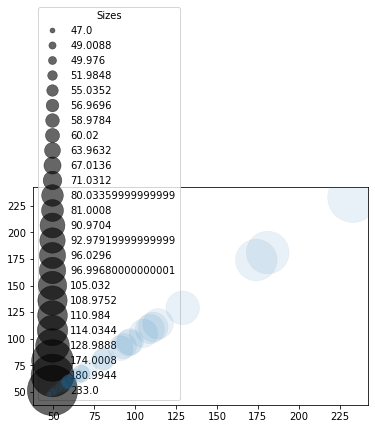

In [23]:
fig, ax = plt.subplots()

scatter = ax.scatter(x=frq_his_eas, y=frq_his_eas, facecolor=None, 
                     s=(minmax_norm(frq_his_eas) + 0.01) * 2500,
                     alpha=0.1, edgecolor="grey", lw=0.5, zorder=10)

handles, labels = scatter.legend_elements(prop="sizes", num=None, alpha=0.6)

labels_list = []
for lab in labels:
    labels_list.append(int(lab.split('{')[1].split('}')[0]))
labels_list = np.array(labels_list)
labels_list = minmax_norm_reverse((labels_list / 2500) - 0.01, frq_his_eas)

legend2 = ax.legend(handles, labels_list, 
                    loc="lower left", title="Sizes")

plt.show()